In [1]:
import torch,imageio,sys,time,os,cmapy
import numpy as np
from tqdm import tqdm
# from .autonotebook import tqdm as tqdm
import matplotlib.pyplot as plt
from omegaconf import OmegaConf
import torch.nn.functional as F

sys.path.append('..')
from models.FactorFields import FactorFields 

from utils import SimpleSampler,TVLoss
from dataLoader import dataset_dict
from torch.utils.data import DataLoader

device = 'cuda'
torch.cuda.set_device(0)

%load_ext autoreload
%autoreload 2

/local/home/anchen/anaconda3/envs/nerfacc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def PSNR(a, b):
	if type(a).__module__ == np.__name__:
		mse = np.mean((a - b) ** 2)
	else:
		mse = torch.mean((a - b) ** 2).item()
	psnr = -10.0 * np.log(mse) / np.log(10.0)
	return psnr


@torch.no_grad()
def eval_img(aabb, reso, idx, shiftment=[0.5,0.5,0.5], chunk=10240):
    y = torch.linspace(0, aabb[0]-1,reso[0])
    x = torch.linspace(0, aabb[1]-1,reso[1])
    yy, xx = torch.meshgrid((y, x), indexing='ij')
    zz = torch.ones_like(xx)*idx
    
    idx = 0
    res = torch.empty(reso[0]*reso[1],train_dataset.imgs.shape[-1])
    coordiantes = torch.stack((xx,yy,zz),dim=-1).reshape(-1,3) + torch.tensor(shiftment)#/(torch.FloatTensor(reso[::-1])-1)*2-1
    # coordiantes = torch.stack((xx,yy),dim=-1).reshape(-1,2) + torch.tensor(shiftment)#/(torch.FloatTensor(reso[::-1])-1)*2-1
    for coordiante in torch.split(coordiantes,chunk,dim=0):

        feats,_ = model.get_coding(coordiante.to(model.device))
        y_recon = model.linear_mat(feats,is_train=False)
        
        res[idx:idx+y_recon.shape[0]] = y_recon.cpu()
        idx += y_recon.shape[0]
    return res.view(reso[0],reso[1],-1), coordiantes

@torch.no_grad()
def eval_img_single(aabb, reso, chunk=10240):
    y = torch.linspace(0, aabb[0]-1,reso[0])
    x = torch.linspace(0, aabb[1]-1,reso[1])
    yy, xx = torch.meshgrid((y, x), indexing='ij')
    
    idx = 0
    res = torch.empty(reso[0]*reso[1],train_dataset.img.shape[-1])
    coordiantes = torch.stack((xx,yy),dim=-1).reshape(-1,2) + 0.5

    for coordiante in tqdm(torch.split(coordiantes,chunk,dim=0)):

        feats,_ = model.get_coding(coordiante.to(model.device))
        y_recon = model.linear_mat(feats,is_train=False)
        
        res[idx:idx+y_recon.shape[0]] = y_recon.cpu()
        idx += y_recon.shape[0]
    return res.view(reso[0],reso[1],-1),coordiantes

def linear_to_srgb(img):
	limit = 0.0031308
	return np.where(img > limit, 1.055 * (img ** (1.0 / 2.4)) - 0.055, 12.92 * img)

def srgb_to_linear(img):
	limit = 0.04045
	return torch.where(img > limit, torch.pow((img + 0.055) / 1.055, 2.4), img / 12.92)

def write_image_imageio(img_file, img, colormap=None, quality=100):
    if colormap == 'turbo':
        shape = img.shape
        img = interpolate(turbo_colormap_data, img.reshape(-1)).reshape(*shape, -1)
    elif colormap is not None:
        img = cmapy.colorize((img * 255).astype('uint8'), colormap)

    if img.dtype != 'uint8':
        img = (img - np.min(img)) / (np.max(img) - np.min(img))
        img = (img * 255.0).astype(np.uint8)

    kwargs = {}
    if os.path.splitext(img_file)[1].lower() in [".jpg", ".jpeg"]:
        if img.ndim >= 3 and img.shape[2] > 3:
            img = img[:, :, :3]
        kwargs["quality"] = quality
        kwargs["subsampling"] = 0
    imageio.imwrite(img_file, img, **kwargs)


def interpolate(colormap, x):
	a = (x * 255.0).astype('uint8')
	b = np.clip(a + 1, 0, 255)
	f = x * 255.0 - a

	return np.stack([colormap[a][..., 0] + (colormap[b][..., 0] - colormap[a][..., 0]) * f,
					 colormap[a][..., 1] + (colormap[b][..., 1] - colormap[a][..., 1]) * f,
					 colormap[a][..., 2] + (colormap[b][..., 2] - colormap[a][..., 2]) * f], axis=-1)


In [3]:
base_conf = OmegaConf.load('../configs/defaults.yaml')
second_conf = OmegaConf.load('../configs/image_set.yaml')
cfg = OmegaConf.merge(base_conf, second_conf)
# cfg.model.coef_init=0.1

# cfg.dataset.datadir = f'/vlg-nfs/anpei/dataset/MNIST/test_img.npy'
# cfg.model.basis_dims = [8,8,8,4,4,4]
# cfg.model.basis_resos = [ 4,  6,  8, 11, 13, 16]
# cfg.model.coeff_reso = 2
# cfg.model.total_params = 3344
# cfg.model.out_dim = 1

cfg.model.basis_type = 'grid'
cfg.model.total_params = 256000
cfg.model.freq_bands = [2. , 3.2, 4.4, 5.6, 6.8, 8.]
cfg.model.basis_resos = (np.array([32,51,70,89,108,128])//2).tolist()
dataset = dataset_dict[cfg.dataset.dataset_name]
train_dataset = dataset(cfg.dataset,cfg.training.batch_size, split='train',N=1000,tolinear=True,HW=512, continue_sampling=False)
train_loader = DataLoader(train_dataset,
              num_workers=8,
              persistent_workers=True,
              batch_size=None,
              pin_memory=True)


batch_size = cfg.training.batch_size
n_iter = cfg.training.n_iters

In [ ]:
model = FactorFields(cfg, device)
tvreg = TVLoss()
# print(model)
print('total parameters: ',model.n_parameters())

grad_vars = model.get_optparam_groups(lr_small=cfg.training.lr_small,lr_large=cfg.training.lr_large)
optimizer = torch.optim.Adam(grad_vars, betas=(0.9, 0.99))#

tv_loss = 0
loss_scale = 1.0
lr_factor = 0.1 ** (1 / n_iter)
pbar = tqdm(range(n_iter))
for (iteration, sample) in zip(pbar,train_loader):
    loss_scale *= lr_factor
    

    coordiantes, pixel_rgb = sample['xy'], sample['rgb']

    basis,coeff = model.get_coding(coordiantes.to(device))
    
    y_recon = model.linear_mat(basis,is_train=True)
    loss = torch.mean((y_recon.squeeze()-pixel_rgb.squeeze().to(device))**2) #+ 4e-3*coeff.abs().mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
        
    psnr = -10.0 * np.log(l2_loss.item()) / np.log(10.0)
    if iteration%100==0:
        pbar.set_description(
                    f'Iteration {iteration:05d}:'
                    + f' loss_dist = {l2_loss.item():.8f}'
                    + f' tv_loss = {tv_loss:.6f}'
                    + f' psnr = {psnr:.3f}'
                )

save_root = '../logs/imageSet/'
os.makedirs(save_root, exist_ok=True)
os.makedirs(save_root,exist_ok=True)
model.save(f'{save_root}/ffhq_ckpt.th')

# In-painting

In [22]:
base_conf = OmegaConf.load('../configs/defaults.yaml')
second_conf = OmegaConf.load('../configs/image.yaml')
cfg = OmegaConf.merge(base_conf, second_conf)
cfg.model.total_params = 256000

cfg.model.basis_type='mlp'

tensor(0.7685)
[40, 40] [16, 26, 35, 45, 54, 64] tensor([32.0000, 19.6923, 14.6286, 11.3778,  9.4815,  8.0000], device='cuda:0')


Iteration 09900: loss_dist = 0.00029065 psnr = 35.366: 100%|███████████████████████████████| 10000/10000 [01:26<00:00, 116.02it/s]
100%|████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 514.34it/s]


993 31.857015272187365
31.857015272187365


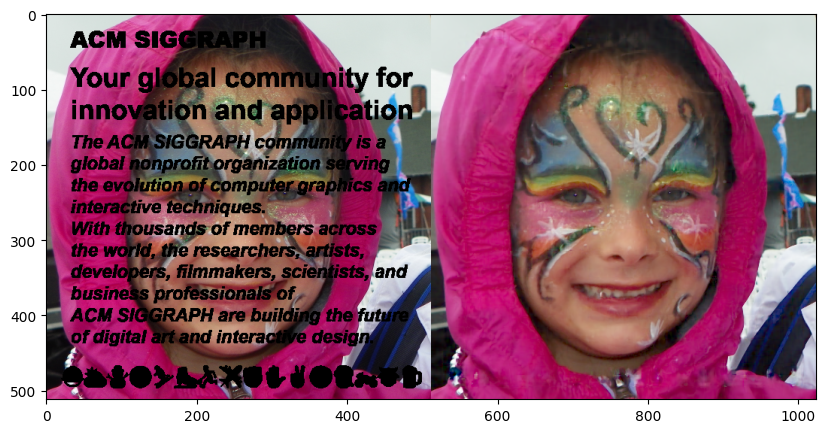

In [23]:
psnrs = []

# define some blocks
# you could use delete region or with a font mask
delete_region = [[290,350,48,48],[300,380,48,48],[180, 407, 48, 48], [223, 263, 48, 48], [233, 150, 48, 48], [374, 119, 48, 48], [4, 199, 48, 48], [180, 234, 48, 48], [173, 39, 48, 48], [408, 308, 48, 48], [227, 177, 48, 48], [46, 330, 48, 48], [213, 26, 48, 48], [90, 44, 48, 48], [295, 61, 48, 48]]

for img_idx in [801]:
    pixel_ratio,continue_sampling = 1.0, False
    save_root = '../logs/imageSet/'
    cfg.dataset.datadir = f'../data/FFHQ/{img_idx:05d}.png'

    dataset = dataset_dict['image']
    train_dataset = dataset(cfg.dataset, cfg.training.batch_size, split='train',tolinear=True, HW=reso, 
                    perscent=pixel_ratio, continue_sampling=continue_sampling, delete_region=delete_region)

    train_loader = DataLoader(train_dataset,
                  num_workers=8,
                  persistent_workers=True,
                  batch_size=None,
                  pin_memory=True)

    img_crop = train_dataset.img.clone()
    img_crop[~train_dataset.mask] = 0
    img_crop = img_crop.view(reso,reso,3)
    
    cfg.model.out_dim = train_dataset.img.shape[-1]
    batch_size = cfg.training.batch_size
    n_iter = cfg.training.n_iters

    H,W = train_dataset.HW
    train_dataset.scene_bbox = [[0., 0.], [W, H]]
    cfg.dataset.aabb = train_dataset.scene_bbox
    
    cfg.defaults.mode = 'image'
    model = sparseCoding(cfg, device)
    
    # load ckpt 
    basises = []
    ckpt = torch.load(f'{save_root}/ffhq_ckpt.th',map_location=device)['state_dict']
    ckpt['coeffs'] = torch.mean(ckpt['coeffs'],dim=2)

    size_target = model.coeffs.data.shape[-1]
    if size_target != ckpt['coeffs'].shape[-1]:
         ckpt['coeffs'] = F.interpolate(ckpt['coeffs'], size=(size_target,size_target), align_corners=True,mode='bilinear')



    model_dict = model.state_dict()
    pretrained_dict = {k: v for k, v in ckpt.items() if 'linear_mat' in k or 'coeffs' in k or 'basises' in k}
    model_dict.update(pretrained_dict) 
    model.load_state_dict(model_dict)
    
    
    ## optimizing
    grad_vars = model.get_optparam_groups(lr_small=cfg.training.lr_small,lr_large=cfg.training.lr_large)
    optimizer = torch.optim.Adam(grad_vars, betas=(0.9, 0.99))#
    model.set_optimizable(['mlp','basis'], False)


    loss_scale = 1.0
    lr_factor = 0.1 ** (1 / n_iter)
    pbar = tqdm(range(10000))
    start = time.time()
    # for iteration in pbar:
    for (iteration, sample) in zip(pbar,train_loader):
        loss_scale *= lr_factor

        coordiantes, pixel_rgb = sample['xy'], sample['rgb']
        feats,coeff = model.get_coding(coordiantes.to(device))
        y_recon = model.linear_mat(feats,is_train=True)
        loss = torch.mean((y_recon.squeeze()-pixel_rgb.to(device))**2) #+ torch.mean(coeff.abs())*1e-4


        psnr = -10.0 * np.log(loss.item()) / np.log(10.0)
        if iteration%100==0:
            pbar.set_description(
                        f'Iteration {iteration:05d}:'
                        + f' loss_dist = {loss.item():.8f}'
                        + f' psnr = {psnr:.3f}'
                    )

        loss = loss * loss_scale
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    H,W = train_dataset.HW
    img,coordinate = eval_img_single(train_dataset.HW,[reso,reso])
    img = img.clamp(0,1.)
    
    if continue_sampling:
        import torch.nn.functional as F
        coordinate_tmp = (coordinate.view(1,1,-1,2))/torch.tensor([W,H])*2-1.0
        img_gt = F.grid_sample(train_dataset.img.view(1,H,W,-1).permute(0,3,1,2),coordinate_tmp, mode='bilinear', 
                               align_corners=False, padding_mode='border').reshape(-1,H,W).permute(1,2,0)
    else:
        img_gt = train_dataset.img.view(H,W,-1)

    
    os.makedirs(f'{save_root}/result/',exist_ok=True)
    write_image_imageio(f'{save_root}/result//{img_idx:03d}_{pixel_ratio:.2f}_prior.png',linear_to_srgb(np.concatenate((img_crop.numpy(),img.numpy()),axis=1)))
    psnrs.append(PSNR(img,img_gt))
    np.savetxt(f'{save_root}/result//{img_idx:03d}_{pixel_ratio:.2f}.txt',[psnrs[-1]])
    print(img_idx,psnrs[-1])
    
print(np.mean(psnrs))
plt.figure(figsize=(10, 5))
plt.imshow(linear_to_srgb(np.concatenate((img_crop.numpy(),img.numpy()),axis=1)))